In [6]:
from PIL import Image
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import math



In [7]:
mat_images = sio.loadmat('./datasets/IMAGES.mat')
imgs = torch.tensor(mat_images['IMAGES'])

In [25]:
def contrast_alpha(I, alpha, alpha_max=10.0, center='mean'):
    
    # check Image value range
    if I.min()!=0 or I.min()!=1:
        #strech
        I = (I - I.min()) / (I.max() - I.min())
    stretched_I = I
    # choose center
    if center == 'mean':
        mu = I.mean()
    elif center == 'median':
        mu = I.median()
    else:
        raise ValueError

    # linear contrast scaling (NO CLAMP)
    base = mu + alpha * (I - mu)

    if alpha <= 1:
        return stretched_I, base

    # explicit binary endpoint
    B = (I > mu).float()
    lam = (alpha - 1) / (alpha_max - 1)
    lam = torch.clamp(torch.tensor(lam), 0., 1.)

    return stretched_I, (1 - lam) * base + lam * B

def add_gaussian_noise(I, sigma):
    """
    I: arbitrary range tensor
    sigma: in [0,inf]
    """
    sigma_I = I.std()
    noise = sigma * torch.randn_like(I) * sigma_I
    return I + noise


def blur_beta_pool(I, beta):
    if beta == 0:
        return I

    H, W = I.shape
    I=I.unsqueeze(0)
    k = int(1 + beta * min(H, W) / 20)
    if k % 2 == 0:
        k += 1

    return F.avg_pool2d(I, kernel_size=(k,k), stride=1, padding=k//2).squeeze(0)

def blur_beta_resample(I,beta,mode='bicubic'):
    """
    Edge-blur via downsample + upsample(bicubic).
    beta >= 0 controls blur strength.
    """

    if beta <= 0:
        return I

    # shape handling
    squeeze = False
    if I.dim() == 2:
        H, W = I.shape
        I = I.unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
        squeeze = True
    elif I.dim() == 3:
        C, H, W = I.shape
        I = I.unsqueeze(0)               # [1,C,H,W]
    else:
        raise ValueError("I must be 2D or 3D tensor")

    scale = 1.0 / (1.0 + beta)  # <1.0
    H_down = max(1, int(H * scale))
    W_down = max(1, int(W * scale))

    # downsample: area mode → averaging
    I_down = F.interpolate(I, size=(H_down, W_down), mode='area')

    # upsample back to original: bicubic / bilinear
    I_blur = F.interpolate(I_down, size=(H, W), mode='bicubic', align_corners=False)

    if squeeze:
        return I_blur.squeeze(0).squeeze(0)
    else:
        return I_blur.squeeze(0)

torch.Size([512, 512, 10])
tensor([0.2549, 0.2594, 0.2690,  ..., 0.7469, 0.7482, 0.7549],
       dtype=torch.float64)


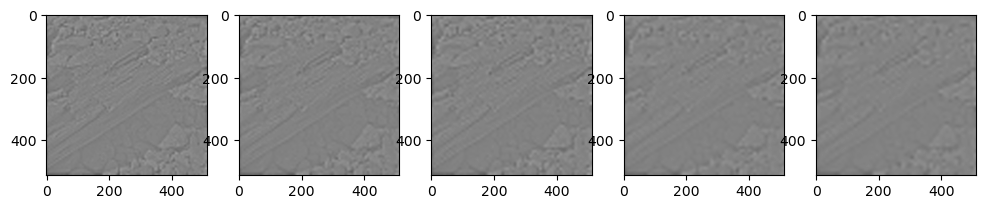

In [26]:
print(imgs.shape)
image = imgs[:,:,0]
stre_img,c_img=contrast_alpha(image,0.5)

vmin = min(stre_img.min(), c_img.min())
vmax = max(stre_img.max(), c_img.max())
print(torch.unique(c_img))
plt.figure(figsize=(12,6))
plt.subplot(1,5,1)
plt.imshow(blur_beta_resample(stre_img,5), cmap='gray',vmin=vmin, vmax=vmax)
#plt.imshow(stre_img, cmap='gray', vmin=vmin, vmax=vmax)
plt.subplot(1,5,2)
plt.imshow(blur_beta_resample(stre_img,6), cmap='gray',vmin=vmin, vmax=vmax)
#plt.imshow(c_img, cmap='gray', vmin=vmin, vmax=vmax)
plt.subplot(1,5,3)
plt.imshow(blur_beta_resample(stre_img,7), cmap='gray',vmin=vmin, vmax=vmax)
#plt.imshow(add_gaussian_noise(stre_img,0.9), cmap='gray', vmin=vmin, vmax=vmax)
plt.subplot(1,5,4)
plt.imshow(blur_beta_resample(stre_img,8), cmap='gray',vmin=vmin, vmax=vmax)
#plt.imshow(blur_beta_pool(stre_img,0.5), cmap='gray', vmin=vmin, vmax=vmax)
plt.subplot(1,5,5)
plt.imshow(blur_beta_resample(stre_img,9), cmap='gray',vmin=vmin, vmax=vmax)
plt.show()
